In [1]:
from sfm.data.sci_data.SFMDecTokenizer import SFMDecTokenizer
import torch
import os

/anaconda/envs/sfm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-03-08 08:45:41,517] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
tokenizer_home = '/hai1/ds_dataset/llama2/llama-2-7b'
tokenizer = SFMDecTokenizer.from_pretrained(
    tokenizer_home,
    prot_spm_path='/blob/shufxi/data/scigpt/ur50bpe/bpe',
    dna_spm_path='/blob/shufxi/data/scigpt/dnabpe/bpe',
    rna_spm_path='/blob/shufxi/data/scigpt/rnabpe/bpe',
)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LlamaTokenizer'. 
The class this function is called from is 'SFMDecTokenizer'.
You are using the default legacy behaviour of the <class 'sfm.data.sci_data.SFMDecTokenizer.SFMDecTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


[2024-03-08 08:50:15.312][INFO]: Loading protein sentencepiece model from /blob/shufxi/data/scigpt/ur50bpe/bpe.model and /blob/shufxi/data/scigpt/ur50bpe/bpe.vocab
[2024-03-08 08:50:16.195][INFO]: Loading DNA sentencepiece model from /blob/shufxi/data/scigpt/dnabpe/bpe.model and /blob/shufxi/data/scigpt/dnabpe/bpe.vocab
[2024-03-08 08:50:16.445][INFO]: Loading RNA sentencepiece model from /blob/shufxi/data/scigpt/rnabpe/bpe.model and /blob/shufxi/data/scigpt/rnabpe/bpe.vocab
[2024-03-08 08:50:16.954][INFO]: Tokenizer has 40014 tokens


In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM
# ckpt_home = '/hai1/shufxi/scigpt/7bv2/stageB/global_step26999/'

# ckpt_home = '/hai1/shufxi/scigpt/7bv3/stageB/global_step11999'
# ckpt_home = '/blob/shufxi/scigpt/7bv3/inst/20240227121523/global_step3585/'
# ckpt_home = '/blob/shufxi/scigpt/7bv3/prot/20240228025826/global_step11715'
ckpt_home = '/hai1/shufxi/scigpt/7bv3/stageB.prot/global_step105720'

def show_ckpt(name, ckpt):
    for k, v in ckpt.items():
        if 'dummy' not in k:
            print(name, k, v.shape)

model = AutoModelForCausalLM.from_pretrained(tokenizer_home)

model_dict = model.state_dict()
ckpt_dict = {}
layer0 = torch.load(os.path.join(ckpt_home, "layer_00-model_states.pt"), map_location=torch.device("cpu"))
ckpt_dict['model.embed_tokens.weight'] = layer0['embed_tokens.weight']
show_ckpt('layer0', layer0)

for l in range(0, 32):
    l_index = str(l + 1).zfill(2)
    layer = torch.load(os.path.join(ckpt_home, f"layer_{l_index}-model_states.pt"), map_location=torch.device("cpu"))
    show_ckpt(l_index, layer)
    for k in layer:
        if "dummy" in k or 'rotary_emb' in k:
            continue
        ckpt_dict[f"model.layers.{l}.{k}"] = layer[k]
layer = torch.load(os.path.join(ckpt_home, "layer_33-model_states.pt"), map_location=torch.device("cpu"))
show_ckpt(33, layer)
ckpt_dict["model.norm.weight"] = layer["norm.weight"]

layer = torch.load(os.path.join(ckpt_home, "layer_34-model_states.pt"), map_location=torch.device("cpu"))
show_ckpt(33, layer)
ckpt_dict["lm_head.weight"] = layer["lm_head.weight"]
model_dict.update(ckpt_dict)

model.resize_token_embeddings(len(tokenizer))
model.load_state_dict(model_dict)

Loading checkpoint shards: 100%|██████████| 2/2 [00:27<00:00, 13.52s/it]


layer0 embed_tokens.weight torch.Size([40014, 4096])
01 self_attn.q_proj.weight torch.Size([4096, 4096])
01 self_attn.k_proj.weight torch.Size([4096, 4096])
01 self_attn.v_proj.weight torch.Size([4096, 4096])
01 self_attn.o_proj.weight torch.Size([4096, 4096])
01 mlp.gate_proj.weight torch.Size([11008, 4096])
01 mlp.up_proj.weight torch.Size([11008, 4096])
01 mlp.down_proj.weight torch.Size([4096, 11008])
01 input_layernorm.weight torch.Size([4096])
01 post_attention_layernorm.weight torch.Size([4096])
02 self_attn.q_proj.weight torch.Size([4096, 4096])
02 self_attn.k_proj.weight torch.Size([4096, 4096])
02 self_attn.v_proj.weight torch.Size([4096, 4096])
02 self_attn.o_proj.weight torch.Size([4096, 4096])
02 mlp.gate_proj.weight torch.Size([11008, 4096])
02 mlp.up_proj.weight torch.Size([11008, 4096])
02 mlp.down_proj.weight torch.Size([4096, 11008])
02 input_layernorm.weight torch.Size([4096])
02 post_attention_layernorm.weight torch.Size([4096])
03 self_attn.q_proj.weight torch.Size

<All keys matched successfully>

In [4]:
model = model.cuda()

In [49]:
short_prot = []
with open('/hai1/kaiyuan/scigpt/ur50/data/sampled_200k_len300.txt', 'r') as f:
    for line in f:
        short_prot.append(line.strip())

print(short_prot[0])

<protein>MEITWGIKTTRFRCGITQTNASNRAWPGYSFSEHGSSAQATLQSISALASVLGIPDANIVMVSQVHGTGVSTLTVLPSRAGERVGTADIIVTNLRLAAPCIRVADCCGVVLYDTANHAVAVVHSGWRGTAAKAVHKALASMNDTYTTHPKNVLAWLSPCASANNYQVGNDVRQALPEWCTQDPAEPEKWYYDNHEAIKSQLISTGMVASNIQVCSHCTIADSRYHSYRRDKELSGRSVVFAVLL</protein>


In [50]:
def compute_score(seq):
    inputs = tokenizer(seq, return_tensors="pt")
    input_ids = inputs["input_ids"].cuda()
    attention_mask = inputs["attention_mask"].cuda()
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
    
    logits = logits[0, :-1, :]
    label = input_ids[0, 1:]

    loss = torch.nn.functional.cross_entropy(logits, label)
    
    return loss.item()

compute_score("<protein>")

0.12034767121076584

: 

In [20]:
from tqdm import tqdm
import random

In [22]:
dist = []
sample = random.sample(short_prot, 10000)
for seq in tqdm(sample):
    dist.append(compute_score(seq))

  0%|          | 2/10000 [00:00<13:20, 12.50it/s]

100%|██████████| 10000/10000 [12:45<00:00, 13.07it/s]


In [23]:
import matplotlib.pyplot as plt

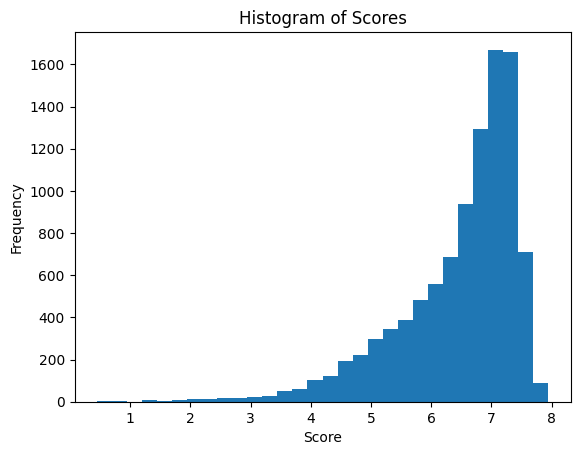

In [24]:
plt.hist(dist, bins=30)  # Change the number of bins as needed
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Histogram of Scores')
plt.show()

In [26]:
import numpy as np

In [27]:
np.mean(dist)

6.462637454223633

In [34]:
len([d for d in dist if d < 5]) / len(dist)

0.0933

In [35]:
np.argmin(dist)

2679

In [36]:
sample[np.argmin(dist)]

'<protein>IGRNMLTQIGCTLNFPISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALTEICTEMEKEGKISKIGPENPYNTPIFAIKKKDSTKWRKLVDFRELNKRTQDFWEVQLGIPHPAGLKKKKSVTVLDVGDAYFSVPLDESFRKYTAFTIPSTNNETPGVRYQYNVLPQGWKGSPAIFQSSMTKILEPFRSKNPEIVIYQYMDDLYVGSDLEIGQHRTKIEELRAHLLSWGFTTPDKKHQKEPPFLWMGYELHP</protein>'

In [40]:
order = np.argsort(dist)

In [41]:
for idx in order[::-1][:10]:
    print(dist[idx], sample[idx])

7.938032627105713 <protein>MVYDLSIEPWRPFRVVTYDDKKDVPITDLTWSLDSTRIIFINQLVWAAYILVTEDHQALNVIG</protein>
7.932953357696533 <protein>MYIHTPFISPCRNSFNQKIILLDTRRSSIEALKVSSSKDLESLIRGEYSLGAFIERKNYRVIPSPTLKYPGDGNYYKGGYISSNHKSLNTNSIQIELAYGVRSSESVAKLNAITFANAFLDFYNFHKFDLKV</protein>
7.927764415740967 <protein>MNPLDVCYASPGTEVLIPTFEISSSGWSESVLICAGFENQACGTEDGRAVTFLAGGLDVSYPTKDNTGSQTVTFAIDGVTGQAQRLIRQAMDADAIIRATLRLYLSTDLSQPSQRPYYLVVSGGSFEGATIRVDGGYFNLIDTNFNRETFNALNAPCIKYL</protein>
7.9024224281311035 <protein>AVNLQAERRGNPNHGGVYRISLAVGSVESRAACQINALTEAKKAPLGTLAIGRLVQAVGGAGRAETPRITRFKRNDPLPWHCTHVIQQ</protein>
7.899400234222412 <protein>MAFNKRKLNSTELKLLYAVLPAEKPAYSKYRETIAGLTVIGYGRFGENNLILGNPEDEPDFTLPSSPVFSFGEMCYGDSCFEVTIHEEEEEKIEIEIRGAEAETLPESVIFDQINSIAFYSPRRVQPEYEPSRKIELIKGEFYLSFIISLRKIILTDLKTGYNALIPVSNFYNELMFVKNIRDPKTALNPRLLFEALGNYTDQDLADAFVYYNKLFRRATINPPQKKNSPPVKEGLLKKIFKGNQE</protein>
7.870851039886475 <protein>LGIQPTEITGTDEATKLERELKRILDDVPELTELFGFRTKKAILQSDRSGITNASPQEGIEGTFPVGEGEAGEGLGLVDVGEQPGQALVEDK

In [47]:
for idx in order[:10]:
    print(dist[idx], sample[idx])

0.4509149193763733 <protein>IGRNMLTQIGCTLNFPISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALTEICTEMEKEGKISKIGPENPYNTPIFAIKKKDSTKWRKLVDFRELNKRTQDFWEVQLGIPHPAGLKKKKSVTVLDVGDAYFSVPLDESFRKYTAFTIPSTNNETPGVRYQYNVLPQGWKGSPAIFQSSMTKILEPFRSKNPEIVIYQYMDDLYVGSDLEIGQHRTKIEELRAHLLSWGFTTPDKKHQKEPPFLWMGYELHP</protein>
0.5071287751197815 <protein>KEALLDTGADDTVLEDINLPGRWKPKMIGGIGGFIKVRQYDQIPIEICGHKAVGTVLVGPTPVNIIGRNLLTQIGCTLNFPISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALTAICDEMEKEGKITKIGPENPYNTPIFAIKKKDSTKWRKLVDFRELNKRTQDFWEVQLGIPHPAGLKKKKSVTVLDVGDAYFSV</protein>
0.5204469561576843 <protein>EICTEMEKEGKISKIGPENPYNTPVFAIKKKDSTKWRKLVDFRELNKRTQDFWEVQLGIPHPAGLKKKKSVTVLDVGDAYFSVPLDKKFRKYTAFTIPSVNNETPGIRYQYNVLPQGWKGSPSIFQCSMTKILEPFRKQNPDIVIYQYMDDLYVGSDLEIGQHRTKIEELRQHLLRWGFTTPDKKHQKEP</protein>
0.6676105856895447 <protein>ICIEMEKEGKISKIGPENPYNTPVFAIKKKDGTKWRKLVDFRELNKRTQDFWEVQLGIPHPAGLKKKKSVTVLDVGDAYFSVPLDENFRKYTAFTIPSINNETPGIRYQYNVLPQGWKGSPAIFQASMTRILEPFRTRNPEMVIYQYMDDLYVGSDLEIGQHRAKIEELREHLLRWGFTTPDKKHQKEPPFLWMGYELHPDKWTVQPITLPEKES<

Bad pipe message: %s [b"\x17\xed9(\xc1\xd0\xbb\xaaJEG1\\\x9d\x8e\xf7\xbf2\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x00"]
Bad pipe message: %s [b'\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c']
Bad pipe message: %s [b"\xf3Jv\xd6\x01}\xe5tf\xe4\xad'\xafBz\xf3\xd0\xd9\x00\x00\xa6\xc0,\xc00"]
Bad pipe message: %s [b'\xcc\x98\xc4\xea^Ld\xf8\xe8\x8c;']
Bad pipe message: %s [b'\xc2\xab\t']
Bad pipe message: %s [b'\xbb\x10\xf4\xa1\xa7.\xff0\n>5\xe5\x1b\x00\x00>\xc0\x14\xc0\n\x009\x008\x007\x006\xc0\x0f\xc0\x05\x005\xc0\x13\xc0\t\x003\x002\x001\x000\xc0\x0e\xc0\x04\x00/\x00\x9a\x00\x99\x00\x98\x00\x97\x00\x96\x00\x07\xc0\x11\xc0\x07\xc0\x0c\xc0\x0

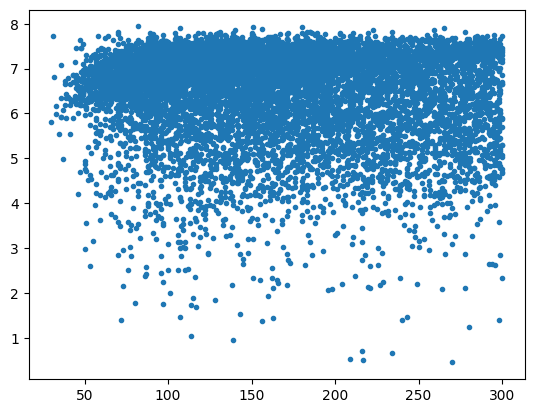

In [46]:
x = [len(s) for s in sample]
plt.plot(x, dist, '.')